In [1]:
from decoder_head.core import *
from fastai2.text.all import *

In [4]:
ls data/es-100

es.wiki.test.tokens  es.wiki.train.tokens  es.wiki.valid.tokens


In [44]:
# !rm -rf data/es-100
# !tar -xvf data/es-100.tar.gz -C data

# !mkdir data/es-100/train
# !mkdir data/es-100/valid
# !mkdir data/es-100/test

# !mv data/es-100/es.wiki.train.tokens data/es-100/train/es.wiki.train.tokens
# !mv data/es-100/es.wiki.valid.tokens data/es-100/valid/es.wiki.valid.tokens
# !mv data/es-100/es.wiki.test.tokens data/es-100/test/es.wiki.test.tokens

es-100/
es-100/es.wiki.test.tokens
es-100/es.wiki.train.tokens
es-100/es.wiki.valid.tokens


In [48]:
# split_file_into_chunks('data/es-100/train/es.wiki.train.tokens')
# split_file_into_chunks('data/es-100/valid/es.wiki.valid.tokens')
# split_file_into_chunks('data/es-100/test/es.wiki.test.tokens')

In [49]:
ls data/es-100/train

0.txt   13.txt  17.txt  20.txt  2.txt  6.txt  es.wiki.train.tokens
10.txt  14.txt  18.txt  21.txt  3.txt  7.txt
11.txt  15.txt  19.txt  22.txt  4.txt  8.txt
12.txt  16.txt  1.txt   23.txt  5.txt  9.txt


In [50]:
# tokenize_folder('data/es-100')

In [2]:
vocab = make_vocab(pd.read_pickle('data/es-100_tok/counter.pkl'), max_vocab=4000)

In [3]:
path = 'data/es-100_tok/'
mult = 4
bs = 80
seq_len = 70

lm = DataBlock(blocks=(TextBlock(vocab=vocab, is_lm=True),),
                get_x=read_tokenized_file,
                get_items=partial(get_text_files, folders=['train', 'valid']),
                splitter=FuncSplitter(lambda itm: itm.parent.name == 'valid'))

dbunch_lm = lm.databunch(path, path=path, bs=bs, seq_len=seq_len)

In [4]:
learn = language_model_learner(
    dbunch_lm,
    pAWD_LSTM,
    opt_func=opt,
    pretrained=False,
    config=awd_lstm_lm_config,
    drop_mult=0.1,
    metrics=[accuracy]
)

In [53]:
torch.mean((torch.cat([tup[0] for tup in dbunch_lm.valid_ds]) == 0).float())

tensor(0.1720)

In [55]:
learn.fit_one_cycle(1, 5e-3,  moms=(0.8, 0.7, 0.8), wd=1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,2.486690,2.816764,0.392779,46:39


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [56]:
# learn.save('pLSTM_es')

In [7]:
learn.load('pLSTM_es')

In [13]:
torch.save(learn.model[0].encoder.weight, 'data/embeddings_es.torch')
torch.save(learn.dbunch.vocab, 'data/vocab_es.torch')

In [6]:
learn.predict('La', n_words=20)

'La Red y el Cementerio Santo Domingo , fueron los primeros en participar , que en septiembre'

In [7]:
learn.optimize_permutation()

In [9]:
preds, targs = learn.get_preds()

In [10]:
aza_loss(learn, preds, targs)

tensor(2.8087, device='cuda:0', grad_fn=<AddBackward0>)

In [11]:
nn.init.kaiming_normal_(learn.model[0].encoder.p)

Parameter containing:
tensor([[ 0.0202,  0.0092,  0.0202,  ...,  0.0065, -0.0105, -0.0176],
        [ 0.0157,  0.0335,  0.0423,  ...,  0.0039,  0.0298, -0.0334],
        [ 0.0148,  0.0290, -0.0304,  ...,  0.0317, -0.0044,  0.0185],
        ...,
        [-0.0219, -0.0451, -0.0346,  ..., -0.0046, -0.0389,  0.0021],
        [-0.0031,  0.0020,  0.0253,  ..., -0.0223,  0.0424, -0.0107],
        [-0.0175, -0.0138, -0.0025,  ..., -0.0412,  0.0085, -0.0363]],
       device='cuda:0', requires_grad=True)

In [12]:
preds, targs = learn.get_preds()
aza_loss(learn, preds, targs, debug=True)

(tensor(564654.6875, device='cuda:0', grad_fn=<AddBackward0>), tensor(6.0058))

In [13]:
learn.loss_func = lambda preds, targs: aza_loss(learn, preds, targs)

In [14]:
learn.fit_one_cycle(1, 1e-3,  moms=(0.8, 0.7, 0.8), wd=1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,2.613976,2.948374,0.377296,39:42


In [15]:
# learn.save('pLSTM_es_permute_embeddings')

In [5]:
learn.load('pLSTM_es_permute_embeddings')

In [6]:
learn.hitInTopN(1, 100), learn.hitInTopN(5, 100)

(0.9899999499320984, 1.0)

In [8]:
acc1 = [(x, learn.hitInTopN(1, x)) for x in range(50,1500,200)]
acc2 = [(x, learn.hitInTopN(2, x)) for x in range(50,1500,200)]
acc3 = [(x, learn.hitInTopN(3, x)) for x in range(50,1500,200)]
acc5 = [(x, learn.hitInTopN(5, x)) for x in range(50,1500,200)]
acc10 = [(x, learn.hitInTopN(10, x)) for x in range(50,1500,200)]

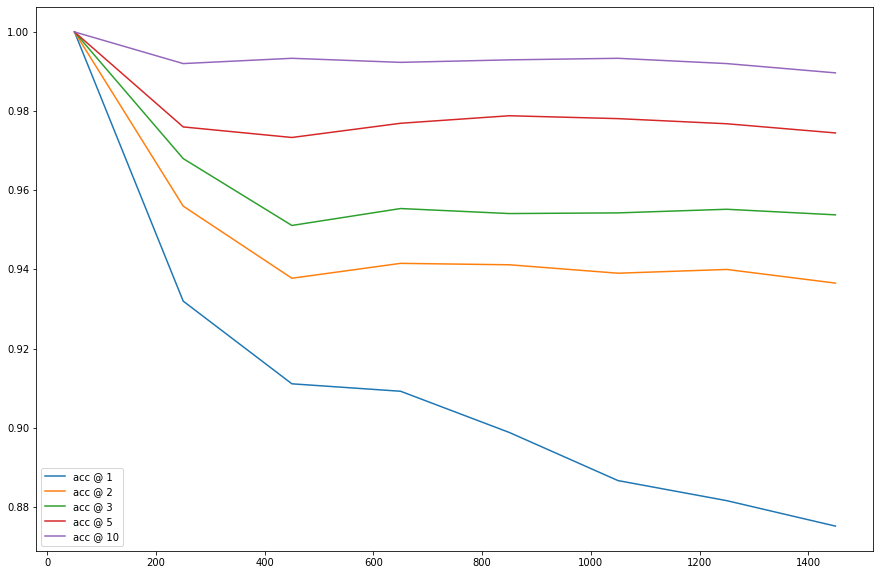

In [9]:
plt.figure(figsize=(15,10))
plt.plot(*zip(*acc1))
plt.plot(*zip(*acc2))
plt.plot(*zip(*acc3))
plt.plot(*zip(*acc5))
plt.plot(*zip(*acc10))
plt.legend([f'acc @ {x}' for x in [1,2,3,5,10]])

In [11]:
learn.print_synonyms(60, 20)

actual word		predictions

años		['años', 'siglos', 'meses', 'décadas', 'temporadas']
son		['son', 'están', 'incluyen', 'serán', 'eran']
año		['año', 'minuto', 'temporada', 'mes', 'siglos']
desde		['desde', 'véase', 'hacia', 'entre', 'durante']
pero		['pero', 'aunque', 'pues', 'etc', 'mientras']
según		['según', 'siguiendo', 'pese', 'véase', 'dependiendo']
durante		['durante', 'tras', 'siguiendo', 'falleció', 'desde']
esta		['esta', 'dicha', 'estas', 'esa', 'este']
hasta		['hasta', 'hacia', 'desde', 'ua', 'llegando']
parte		['parte', 'depende', 'lado', 'mitad', 'consecuencia']
ha		['ha', 'han', 'he', 'ee.uu', 'nos']
sobre		['sobre', 'ante', 'hacia', 'siguiendo', 'acerca']
censo		['censo', 'contaba', 'township', 'plazo', 'ayuntamiento']
había		['había', 'habían', 'hubiera', 'habría', 'puso']
personas		['personas', 'pacientes', 'individuos', 'familias', 'mujeres']
«		['«', '‘', '¿', '“', 'frase']
»		['»', '”', '’', '¡', '!']
donde		['donde', 'quienes', 'cuyo', 'cuya', 'cuyos']
le		['le', 